<h1>WSG Analysis</h1><br>
In this notebook, I will be exploring a dataset that has data on the Warsong Gulch battleground in World of Warcraft. The dataset comes from the Kaggle website and can be found at https://www.kaggle.com/cblesa/world-of-warcraft-battlegrounds#wowwg.csv. My goal with this dataset is to see if I can build a model to predict winning teams in a battleground. Since I would like to know the chances of a team winning in advance, I don't want to rely on damage or healing numbers to make my predictions. Thus, I will focus on identifying the strongest classes for carrying flags and dealing damage, and hopefully team composition will be enough to give my model some predictive power.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns

In [2]:
wsg_df = pd.read_csv(r'C:\users\efrut\OneDrive\Desktop\Coding practice\Warcraft Battleground\wowwg.csv')

In [3]:
wsg_df.head()

,Code,Faction,Class,KB,D,HK,DD,HD,FC,FR,Honor,Win,Lose,Rol,BE
0,WG1,Horde,Hunter,1,3,14,48155,6641,1.0,NaN,532,1.0,NaN,dps,NaN
1,WG1,Horde,Death Knight,1,3,12,27025,7106,NaN,NaN,377,1.0,NaN,dps,NaN
2,WG1,Alliance,Paladin,0,1,19,824,93879,NaN,NaN,252,NaN,1.0,heal,NaN
3,WG1,Alliance,Paladin,1,2,25,7046,98599,NaN,NaN,274,NaN,1.0,heal,NaN
4,WG1,Alliance,Rogue,2,3,23,65483,19629,NaN,NaN,268,NaN,1.0,dps,NaN


It looks like a lot of the rows have null values where a 0 would make more sense. Leaving this as is will make things harder for me than necessary. Let's replace these null values with 0.

In [4]:
wsg_df = wsg_df.fillna(0)
wsg_df.head()

,Code,Faction,Class,KB,D,HK,DD,HD,FC,FR,Honor,Win,Lose,Rol,BE
0,WG1,Horde,Hunter,1,3,14,48155,6641,1.0,0.0,532,1.0,0.0,dps,0.0
1,WG1,Horde,Death Knight,1,3,12,27025,7106,0.0,0.0,377,1.0,0.0,dps,0.0
2,WG1,Alliance,Paladin,0,1,19,824,93879,0.0,0.0,252,0.0,1.0,heal,0.0
3,WG1,Alliance,Paladin,1,2,25,7046,98599,0.0,0.0,274,0.0,1.0,heal,0.0
4,WG1,Alliance,Rogue,2,3,23,65483,19629,0.0,0.0,268,0.0,1.0,dps,0.0


This is much better. Let's make sure everything else looks normal then move on

In [5]:
wsg_df.dtypes

Code        object
Faction     object
Class       object
KB           int64
D            int64
HK           int64
DD           int64
HD           int64
FC         float64
FR         float64
Honor        int64
Win        float64
Lose       float64
Rol         object
BE         float64
dtype: object

This looks fine for now, so let's move on.

<h3>Flag Captures by Class</h3><br>
My first interest is finding out which classes are the best at capturing flags in the battleground.

In [6]:
# I want a dataframe that shows each class and the total number of flag captures they have made

fcapture_df = wsg_df.groupby('Class')['FC'].sum().to_frame().reset_index().sort_values(by='FC')
fcapture_df

,Class,FC
3,Hunter,1.0
10,Warlock,1.0
7,Priest,5.0
0,Death Knight,6.0
4,Mage,7.0
8,Rogue,7.0
9,Shaman,8.0
2,Druid,10.0
6,Paladin,11.0
5,Monk,14.0


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 <a list of 12 Text xticklabel objects>)

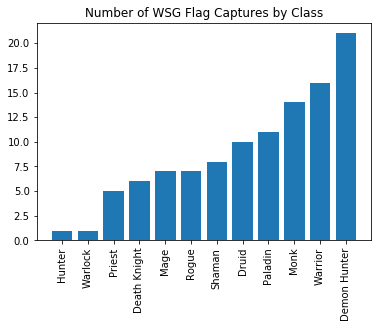

In [7]:
%matplotlib inline
x_caps=fcapture_df['Class']
y_caps=fcapture_df['FC']

plt.bar(x_caps,y_caps)
plt.title('Number of WSG Flag Captures by Class')
plt.xticks(rotation=90)

We have found the classes that are the top flag carriers in WSG. They are<br>
<ol>
    <li>Demon Hunter</li>
    <li>Warrior</li>
    <li>Monk</li>
    <li>Paladin</li>
    <li>Druid</li>
</ol><br>
I want to check the distribution of the classes within our data to make sure no single class is significantly overrepresented in the battlegrounds, which could alter our results here

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 <a list of 12 Text xticklabel objects>)

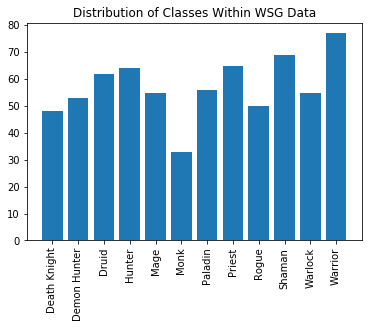

In [8]:
class_x = wsg_df.groupby('Class').size().reset_index(name='counts')['Class']
class_y = wsg_df.groupby('Class').size().reset_index(name='counts')['counts']

plt.bar(class_x, class_y)
plt.title('Distribution of Classes Within WSG Data')
plt.xticks(rotation=90)

The class counts support the conclusion above. Demon Hunter seems to be the best flag carrier. With Monks comparatively underrepresented, they may be a better flag carrier than warriors, who are the most represented class, but I believe both should be included in the top 5.

In [9]:
best_fc=['Demon Hunter','Warrior','Monk','Paladin','Druid']

<h3>Deadliest Classes</h3><br>
In the previous section, we found the best flag carriers in our data. Let's follow a similar method and find the deadliest classes across our Warsong Gulch data.

In [10]:
kills_df = wsg_df.groupby('Class')['KB'].sum().to_frame().reset_index().sort_values(by='KB')
kills_df

,Class,KB
5,Monk,47
9,Shaman,77
0,Death Knight,141
8,Rogue,149
6,Paladin,162
2,Druid,171
1,Demon Hunter,186
7,Priest,193
4,Mage,195
10,Warlock,224


I think I want to divide the number of KBs for each class by the count of each class to find the expected KBs per class player. Let's get the counts for each class.

In [11]:
class_counts_df = wsg_df.groupby('Class').size().to_frame().reset_index()
class_counts_df.columns=['Class','Counts']



In [12]:
kb_counts_df = pd.merge(kills_df, class_counts_df, on='Class')
kb_counts_df

,Class,KB,Counts
0,Monk,47,33
1,Shaman,77,69
2,Death Knight,141,48
3,Rogue,149,50
4,Paladin,162,56
5,Druid,171,62
6,Demon Hunter,186,53
7,Priest,193,65
8,Mage,195,55
9,Warlock,224,55


Perfect! Now, lets make a new column that has KB divide by count

In [13]:
kb_counts_df['KB/Count'] = kb_counts_df['KB']/kb_counts_df['Counts']
kb_counts_df = kb_counts_df.sort_values(by='KB/Count')
kb_counts_df

,Class,KB,Counts,KB/Count
1,Shaman,77,69,1.115942
0,Monk,47,33,1.424242
5,Druid,171,62,2.758065
4,Paladin,162,56,2.892857
2,Death Knight,141,48,2.937500
7,Priest,193,65,2.969231
3,Rogue,149,50,2.980000
6,Demon Hunter,186,53,3.509434
8,Mage,195,55,3.545455
10,Hunter,228,64,3.562500


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 <a list of 12 Text xticklabel objects>)

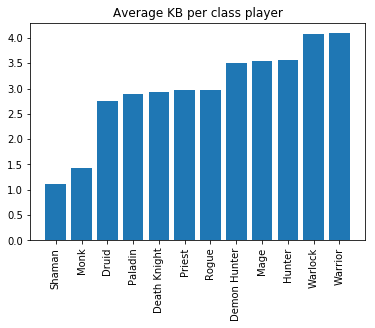

In [14]:
plt.bar(kb_counts_df['Class'],kb_counts_df['KB/Count'])
plt.title('Average KB per class player')
plt.xticks(rotation=90)

I think this is a good representation of the deadliest classes in WSG. As I did with the flag carriers, I'll look at the top 5 since there seems to be a bit of a drop afterwards.<ol>
    <li>Warrior</li>
    <li>Warlock</li>
    <li>Hunter</li>
    <li>Mage</li>
    <li>Demon Hunter</li>
   </ol>
We'll call these the best dps.

In [15]:
best_dps=['Warrior','Warlock','Hunter','Mage','Demon Hunter']

<h3>Data Aggregation</h3><br>
Now that we know which classes do are the best at getting killing blows and flag carrying, I want a dataframe that has these stats for each team in each battleground. For the Alliance and Horde in each battleground, I would like to see, for example, the number of good flag carriers, number of good dps, number of healers, and which faction won. 

In [16]:
wsg_grouped=wsg_df.groupby(['Code','Faction'])

In [17]:
bg_array=[] # create empty lists for the bg codes and the factions
faction_array=[]

for bg, bg_df in wsg_grouped: # iterate through the groupedby object
    bg_array.append(bg[0]) # append the bg list with the first element in bg
    faction_array.append(bg[1]) # append the factions list with the second element in bg

print(bg_array)
print(faction_array)
    

['WG1', 'WG1', 'WG10', 'WG10', 'WG11', 'WG11', 'WG12', 'WG12', 'WG13', 'WG13', 'WG14', 'WG14', 'WG15', 'WG15', 'WG16', 'WG16', 'WG17', 'WG17', 'WG18', 'WG18', 'WG19', 'WG19', 'WG2', 'WG2', 'WG20', 'WG20', 'WG21', 'WG21', 'WG22', 'WG22', 'WG23', 'WG23', 'WG24', 'WG24', 'WG25', 'WG25', 'WG26', 'WG26', 'WG27', 'WG27', 'WG28', 'WG28', 'WG29', 'WG29', 'WG3', 'WG3', 'WG30', 'WG30', 'WG31', 'WG31', 'WG32', 'WG32', 'WG33', 'WG33', 'WG34', 'WG34', 'WG35', 'WG35', 'WG4', 'WG4', 'WG5', 'WG5', 'WG6', 'WG6', 'WG7', 'WG7', 'WG8', 'WG8', 'WG9', 'WG9']
['Alliance', 'Horde', 'Alliance', 'Horde', 'Alliance', 'Horde', 'Alliance', 'Horde', 'Alliance', 'Horde', 'Alliance', 'Horde', 'Alliance', 'Horde', 'Alliance', 'Horde', 'Alliance', 'Horde', 'Alliance', 'Horde', 'Alliance', 'Horde', 'Alliance', 'Horde', 'Alliance', 'Horde', 'Alliance', 'Horde', 'Alliance', 'Horde', 'Alliance', 'Horde', 'Alliance', 'Horde', 'Alliance', 'Horde', 'Alliance', 'Horde', 'Alliance', 'Horde', 'Alliance', 'Horde', 'Alliance', 'Ho

In [18]:
bg_faction = np.column_stack((bg_array,faction_array))
# create a numpy array from our lists - will turn into DF next

In [19]:
stats_df = pd.DataFrame(bg_faction, columns=['BG','Faction'])
# create a dataframe out of our np array and label the columns
stats_df.head()

,BG,Faction
0,WG1,Alliance
1,WG1,Horde
2,WG10,Alliance
3,WG10,Horde
4,WG11,Alliance


Now we have a dataframe thats holds only the battlegrounds we have data for and the factions in them. I want to populate this dataframe with some stats for each team in each battleground. 

In [20]:
# we want to pass this function a dataframe from our groupby object above and have it count the good flag carriers
def count_fc(df): # we will use the best_fc list created above to count the number of good flag carriers in each team
    temp=pd.DataFrame(df[['Class']])
    temp['in']=temp.Class.isin(best_fc)
    # return temp['in'].value_counts()[True] # this does not work - key error if there is no fc thus no true
    return (temp['in']==True).sum()
    

def count_dps(df): # same as above but counts good dps using best_dps
    temp=pd.DataFrame(df[['Class']])
    temp['in']=temp.Class.isin(best_dps)
    # return temp['in'].value_counts()[True]
    return (temp['in']==True).sum()
    

def count_healer(df): # counts the number of healers
    # return df['Rol'].value_counts()['heal']
    counter=0
    temp=df['Rol'].tolist()
    for role in temp:
        if role == 'heal':
            counter+=1
    return counter


def won(df):
    if df['Win'].mean() == 1:
        return 1
    return 0

In [21]:
# now we want to test our functions by passing them a dataframe from our groupby object
won(wsg_grouped.get_group(('WG1','Alliance')))

0

In [22]:
 wsg_grouped.get_group(('WG1','Alliance')) # check for accuracy

,Code,Faction,Class,KB,D,HK,DD,HD,FC,FR,Honor,Win,Lose,Rol,BE
2,WG1,Alliance,Paladin,0,1,19,824,93879,0.0,0.0,252,0.0,1.0,heal,0.0
3,WG1,Alliance,Paladin,1,2,25,7046,98599,0.0,0.0,274,0.0,1.0,heal,0.0
4,WG1,Alliance,Rogue,2,3,23,65483,19629,0.0,0.0,268,0.0,1.0,dps,0.0
7,WG1,Alliance,Priest,9,5,24,123000,34687,0.0,1.0,269,0.0,1.0,dps,0.0
9,WG1,Alliance,Priest,0,1,25,12566,36734,0.0,0.0,276,0.0,1.0,heal,0.0
10,WG1,Alliance,Rogue,3,1,10,22327,2394,0.0,0.0,171,0.0,1.0,dps,0.0
11,WG1,Alliance,Demon Hunter,0,5,15,29664,4364,0.0,0.0,242,0.0,1.0,dps,0.0
14,WG1,Alliance,Warlock,8,2,24,101000,21853,0.0,0.0,270,0.0,1.0,dps,0.0
15,WG1,Alliance,Warlock,5,3,25,124000,27687,0.0,0.0,274,0.0,1.0,dps,0.0
16,WG1,Alliance,Druid,0,0,17,6796,2738,0.0,0.0,248,0.0,1.0,dps,0.0


All of our functions work!! Now lets create some new columns in our stats dataframe using them.

In [23]:
# stats_df['num_fc']=count_fc(wsg_grouped.get_group((stats_df['BG'].iloc[0],stats_df['Faction'].iloc[0])))
numfc=[]
numdps=[]
heals=[]
won_lost=[]
for i in range(len(bg_array)):
    df=wsg_grouped.get_group((bg_array[i],faction_array[i]))
    
    count = count_fc(df)
    countd=count_dps(df)
    counth=count_healer(df)
    win=won(df)
    
    numfc.append(count)
    numdps.append(countd)
    heals.append(counth)
    won_lost.append(win)
    # numfc.append(count_fc(wsg_grouped.get_group((bg_array[i],faction_array[i]))))
    

stats_df['fc']=numfc
stats_df['dps']=numdps
stats_df['heals']=heals
stats_df['won']=won_lost
stats_df.head()

,BG,Faction,fc,dps,heals,won
0,WG1,Alliance,4,3,3,0
1,WG1,Horde,6,4,2,1
2,WG10,Alliance,0,2,2,1
3,WG10,Horde,4,4,3,0
4,WG11,Alliance,5,3,3,1


Now we have some stats for each team in the battlegrounds. Lets see whether these 3 stats are enough to predict which team won the battleground. We can start with some visualizations

Text(0.5,1,'Wins per faction')

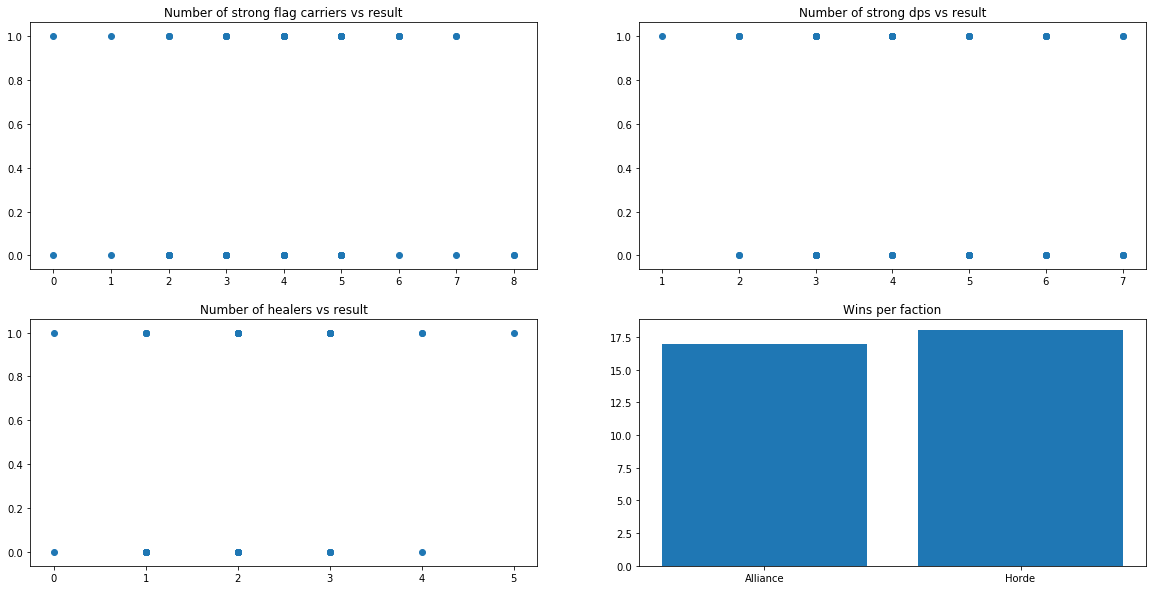

In [24]:
plt.rcParams['figure.figsize'] = (20, 10)
fig, axes = plt.subplots(nrows = 2, ncols = 2)

axes[0,0].scatter(x='fc',y='won',data=stats_df)
axes[0,0].set_title('Number of strong flag carriers vs result')

axes[0,1].scatter(x='dps', y='won', data=stats_df)
axes[0,1].set_title('Number of strong dps vs result')

axes[1,0].scatter(x='heals', y='won', data=stats_df)
axes[1,0].set_title('Number of healers vs result')

df1=stats_df.groupby('Faction')['won'].sum().reset_index(name='sum')
axes[1,1].bar(df1['Faction'],df1['sum'])
axes[1,1].set_title('Wins per faction')

This doesn't look very promising. I was hoping that these scatter plots might show some kind of a trend, but there doesn't seem to be much here. We can try a logistic regression to see if it seems to do anything

In [25]:
from sklearn.model_selection import train_test_split

features=['fc','dps','heals']

stats_features=stats_df[features]
stats_target=stats_df['won']

x_train,x_test,y_train,y_test=train_test_split(stats_features, stats_target, test_size=0.2, random_state=11)

print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_test: ", x_test.shape)
print("y_test: ", y_test.shape)

x_train:  (56, 3)
y_train:  (56,)
x_test:  (14, 3)
y_test:  (14,)


In [26]:
from sklearn.linear_model import LogisticRegression

lreg=LogisticRegression()

In [27]:
lreg.fit(x_train,y_train.ravel())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [28]:
predict=lreg.predict(x_test)

In [29]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_test, predict) * 100)

57.14285714285714


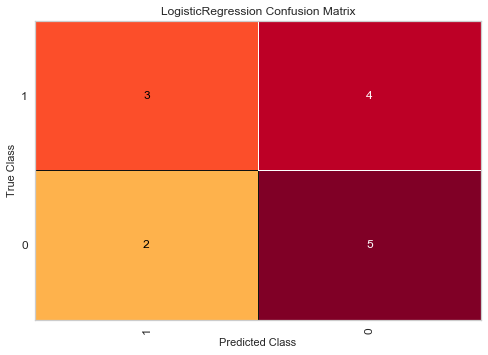

In [30]:
from yellowbrick.classifier import ConfusionMatrix

classes=[1,0]
cm = ConfusionMatrix(lreg, classes=classes)
cm.fit(x_train, y_train)
cm.score(x_test, y_test.ravel())
cm.poof()

This model does not seem to have much predictive ability. 57% accuracy is slightly better than the 50% you would expect with random guessing, but not by much. Additionally, the model seems a bit better at predicting a loss than a win. It may be that it is easier to predict a losing team than a winning one. It makes sense that a team with, say, 0 good flag carriers and 1 healer will struggle, and maybe that loss is easier to predict.<br><br>
I wonder if a model might predict better if the goal was to predict the winner given a single battleground instance. The one I built above only considers one team at a time and tries to label it as a winner or loser. We should be able to aggregate the data further to have only one row per battleground instance. Within the row, we can include data on both the Alliance and Horde team and note which team won. 

<h1>A New Approach</h1>

In [37]:
bg_grouped = stats_df.groupby('BG')

alli_fc=[]
alli_dps=[]
alli_heal=[]

horde_fc=[]
horde_dps=[]
horde_heal=[]

alli_won=[]

for bg,bg_df in bg_grouped:
    temp_fc=bg_df['fc'].tolist()
    alli_fc.append(temp_fc[0])
    horde_fc.append(temp_fc[1])
    
    temp_dps=bg_df['dps'].tolist()
    alli_dps.append(temp_dps[0])
    horde_dps.append(temp_dps[1])
    
    temp_heal=bg_df['heals'].tolist()
    alli_heal.append(temp_heal[0])
    horde_heal.append(temp_heal[1])
    
    alli_won.append(bg_df['won'].tolist()[0])
    


In [39]:
print(len(alli_fc))
print(len(alli_heal))
print(len(horde_fc))
print(len(horde_heal))
print(len(alli_won))

35
35
35
35
35


In [42]:
bgs = list(set(bg_array))
bgs = sorted(bgs)

In [44]:
bg_dict = {'BG':bgs,'alli_fc':alli_fc,'alli_dps':alli_dps,'alli_heal':alli_heal,'horde_fc':horde_fc,'horde_dps':horde_dps,
           'horde_heal':horde_heal,'alli_won':alli_won}
bgframe=pd.DataFrame(bg_dict)
bgframe.head()

,BG,alli_fc,alli_dps,alli_heal,horde_fc,horde_dps,horde_heal,alli_won
0,WG1,4,3,3,6,4,2,0
1,WG10,0,2,2,4,4,3,1
2,WG11,5,3,3,2,5,2,1
3,WG12,2,2,1,3,6,1,0
4,WG13,8,5,2,5,6,3,0


Now we have the dataframe we need

In [47]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

lreg_model = LogisticRegression(random_state=1)
tree_classifier = DecisionTreeClassifier(random_state=1)
forest_classifier = RandomForestClassifier(random_state=1)

f=['alli_fc','alli_dps','alli_heal','horde_fc','horde_dps','horde_heal']
bg_features=bgframe[f]
bg_target=bgframe['alli_won']

In [48]:
train_x,test_x,train_y,test_y=train_test_split(bg_features, bg_target, test_size=0.2, random_state=11)

In [49]:
lreg_model.fit(train_x,train_y)
tree_classifier.fit(train_x,train_y)
forest_classifier.fit(train_x,train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [50]:
lreg_predict=lreg_model.predict(test_x)
tree_predict=tree_classifier.predict(test_x)
forest_predict=forest_classifier.predict(test_x)

In [52]:
print('Logistic Regression accuracy: ', accuracy_score(test_y,lreg_predict))
print('Tree accuracy: ', accuracy_score(test_y,tree_predict))
print('Forest accuracy: ', accuracy_score(test_y,forest_predict))

Logistic Regression accuracy:  0.5714285714285714
Tree accuracy:  0.5714285714285714
Forest accuracy:  0.2857142857142857
